## `Named Entity Recognition (NER)`

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib, os
from sklearn.model_selection import train_test_split
import tensorflow as tf

np.random.seed(45)
tf.random.set_seed(45)
plt.style.use("ggplot")

* `Load the Dataset`

In [4]:
FILEPATH = os.path.join(os.getcwd(), '..', 'data', 'ner_dataset.csv')

df = pd.read_csv(FILEPATH, encoding='latin1')
df = df.fillna(method='ffill')
df.head(20)

C:\Users\YUSSEF\AppData\Local\Temp\ipykernel_13244\3540681445.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Sentence #  1048575 non-null  object
 1   Word        1048575 non-null  object
 2   POS         1048575 non-null  object
 3   Tag         1048575 non-null  object
dtypes: object(4)
memory usage: 32.0+ MB


In [5]:
# Check uinuqe in Tag column
df['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [6]:
print('Unique words in corpus:', df['Word'].nunique())
print('Unique tags in corpus:', df['Tag'].nunique())

Unique words in corpus: 35177
Unique tags in corpus: 17


In [7]:
# Get unique words in corpus to a list
words = df['Word'].unique().tolist()

# 'ENDPAD' make that word for padding shorter sequences
words.append('ENDPAD')

# Length of unique words in corpus
num_words = len(words)
num_words

35178

In [8]:
# Get unique tags in the corpus to a list
tags = df['Tag'].unique().tolist()

# Length of unique tags in corpus
num_tags = len(tags)
num_tags

17

In [9]:
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [15]:
# Let's test on some samples
df_test = df.iloc[:50]

# Aggregation function for looping over the (Word, POS, Tag)
agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                s['POS'].values.tolist(),
                                                s['Tag'].values.tolist())]

grouped = df_test.groupby('Sentence #').apply(agg_func)
sentences = [s for s in grouped]
grouped

C:\Users\YUSSEF\AppData\Local\Temp\ipykernel_13244\2411288196.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_test.groupby('Sentence #').apply(agg_func)


Sentence #
Sentence: 1    [(Thousands, NNS, O), (of, IN, O), (demonstrat...
Sentence: 2    [(Families, NNS, O), (of, IN, O), (soldiers, N...
dtype: object

* `Retrieve Sentences and Corresponsing Tags`

In [17]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sets = 1
        self.data = data

        self.agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                    s['POS'].values.tolist(),
                                                    s['Tag'].values.tolist())]

        self.grouped = self.data.groupby('Sentence #').apply(self.agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped[f"Sentence: {self.n_sent}"]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(df)
sentences = getter.sentences

C:\Users\YUSSEF\AppData\Local\Temp\ipykernel_13244\105192383.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby('Sentence #').apply(self.agg_func)


In [20]:
print(len(sentences))
# sentences[200]

47959


* `Mapping between Sentences and Tags`

In [21]:
# Indexing words and tags
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

* `Padding Sentences`

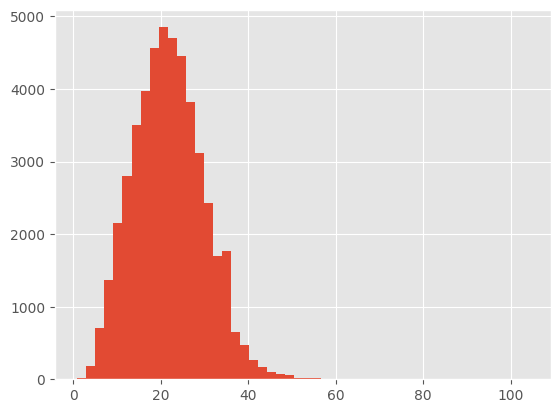

In [22]:
# Histogram represening the length of each sentences
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [23]:
# config
MAX_SEQUENCE_LENGTH = 50
EMBED_SIZE = 100
VOCAB_SIZE = num_words
NUM_OUTPUTS = num_tags
BATCH_SIZE = 32
EPOCHS = 5

In [24]:
# Indexing each word in each sentence (nested loop), for both words (X - Features), and tags (y - target)
X = [[word2idx[w[0]] for w in s] for s in sentences]
y = [[tag2idx[w[2]] for w in s] for s in sentences]

# padding
X = tf.keras.preprocessing.sequence.pad_sequences(sequences=X, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post', value=word2idx['ENDPAD'])  # words (X - Features)
y = tf.keras.preprocessing.sequence.pad_sequences(sequences=y, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post', value=tag2idx['O'])  # tags (y - target)

* `Split Dataset`

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((38367, 50), (9592, 50), (38367, 50), (9592, 50))

In [26]:
y  # In Target (tags) : the first value in the second row (2)

array([[0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [0, 0, 7, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 6, ..., 0, 0, 0]])

In [27]:
tag2idx   # see what (2) refer in tags (B-gpe) --> (Geopolitical Entity)

{'O': 0,
 'B-geo': 1,
 'B-gpe': 2,
 'B-per': 3,
 'I-geo': 4,
 'B-org': 5,
 'I-org': 6,
 'B-tim': 7,
 'B-art': 8,
 'I-art': 9,
 'I-per': 10,
 'I-gpe': 11,
 'I-tim': 12,
 'B-nat': 13,
 'B-eve': 14,
 'I-eve': 15,
 'I-nat': 16}

In [28]:
X  # In Features (words) : the first value in the second row (125)

array([[    1,     2,     3, ..., 35178, 35178, 35178],
       [  125,   126,   127, ..., 35178, 35178, 35178],
       [  943,   944,   364, ..., 35178, 35178, 35178],
       ...,
       [ 3184,   111,    69, ..., 35178, 35178, 35178],
       [ 6503,  3207,    94, ..., 35178, 35178, 35178],
       [   62,   581,   820, ..., 35178, 35178, 35178]])

In [29]:
idx2word = {v: k for k, v in word2idx.items()}
idx2word.get(125)

'Iranian'

----

* `Model`